In [1]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import metrics
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input
from keras.layers import TimeDistributed, Bidirectional, MultiHeadAttention, LayerNormalization
from keras.layers import GlobalAveragePooling1D, Convolution1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from skopt.space import Integer, Real, Categorical
from skopt import gp_minimize

import warnings
warnings.filterwarnings("ignore")
rand_num = random.randint(1, 100)
rand_num = 20 # 89 20

## 数据集生成

原理：从正样本类和负样本类中随机选则若干样本建立数据集

In [2]:
def create_dataset(path, trainNum, maxlen, test_percent, testNum):
    labels = {"pt": os.listdir(path)[1], "nt": os.listdir(path)[0]}
    l_path = {"pt": path + '/' + labels['pt'], "nt": path + '/' + labels['nt']}
    l_counts = {"pt": len(os.listdir(l_path["pt"])), "nt": len(os.listdir(l_path["nt"]))}
    pf = os.listdir(l_path["pt"])
    nf = os.listdir(l_path["nt"])
    random.seed(rand_num) ## 20
    
    # 划分训练集和测试集
    pt_test = random.sample(pf, int(l_counts["pt"]*test_percent))
    nt_test = random.sample(nf, int(l_counts["nt"]*test_percent))
    pt_train = [i for i in pf if i not in pt_test]
    nt_train = [j for j in nf if j not in nt_test]
    
    # 随机选取数据，生成训练数据集
    px = np.zeros([trainNum, maxlen])
    py = np.zeros([trainNum, 1])
    nx = np.zeros([trainNum, maxlen])
    ny = np.zeros([trainNum, 1]) 
    
    print("训练集！------------>")
    print("正样本")
    for p in range(int(trainNum)):
        pFilePath = l_path["pt"] + '/' + random.sample(pt_train,1)[0]
        pdf = pd.read_excel(pFilePath, header=None)
        parray = np.array(pdf[3])[-maxlen:]
        px[p] = parray
        py[p] = 0
    print("负样本")
    for n in range(int(trainNum)):
        nFilePath = l_path['nt'] + '/' + random.sample(nt_train,1)[0]
        ndf = pd.read_excel(nFilePath, header=None)
        narray = np.array(ndf[3])[-maxlen:]
        nx[n] = narray
        ny[n] = 1
    
    xTrain = np.vstack((px,nx))
    yTrain = np.vstack((py,ny))
    
    print("测试集！------------>")
    # 生成测试集
    ptx = np.zeros([testNum, maxlen])
    pty = np.zeros([testNum, 1])
    ntx = np.zeros([testNum, maxlen])
    nty = np.zeros([testNum, 1]) 
    
    print("正样本")
    for tp in range(testNum):
        ptFilePath = l_path["pt"] + '/' + random.sample(pt_test,1)[0]
        ptdf = pd.read_excel(ptFilePath, header=None)
        ptarray = np.array(ptdf[3])[-maxlen:]
        ptx[tp] = ptarray
        pty[tp] = 0
    print("负样本")
    for tn in range(testNum):
        ntFilePath = l_path['nt'] + '/' + random.sample(nt_test,1)[0]
        ntdf = pd.read_excel(ntFilePath, header=None)
        ntarray = np.array(ntdf[3])[-maxlen:]
        ntx[tn] = ntarray
        nty[tn] = 1
    
    xTest = np.vstack((ptx,ntx))
    yTest = np.vstack((pty,nty))
    
    print("完成！")
    return xTrain, yTrain, xTest, yTest

In [3]:
# 归一化函数
def MeanNorm(X):
    X = X - X.mean()
    return X

def MinMaxNorm(X):
    X_min = np.min(X)
    X_max = np.max(X)
    X = (X - X_min) / (X_max - X_min)
    return X

def standardize(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std

In [4]:
path = "datas/Taiwan-ChiChi/T_A_V_D"  # 数据文件路径
trainNum = 300  # 单一类别样本数量
testNum = 100
maxlen = 4000  # 向后截取波形数量片段，相乘等于截取总数
test_percent = 0.2  # 测试集占比

xTrain, yTrain, xTest, yTest = create_dataset(path, trainNum, maxlen, test_percent, testNum)

训练集！------------>
正样本
负样本
测试集！------------>
正样本
负样本
完成！


In [5]:
# 归一化
for i in range(xTrain.shape[0]):
    xTrain[i] = standardize(xTrain[i])
    
for j in range(xTest.shape[0]):
    xTest[j] = standardize(xTest[j])

In [6]:
# 划分片段
clips = [10, 400]  # 向后截取波形数量片段，相乘等于截取总数
xTrain = xTrain.reshape(xTrain.shape[0], clips[0], clips[1])
xTest = xTest.reshape(xTest.shape[0], clips[0], clips[1])

In [7]:
# 划分训练集与验证集
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size=0.2, random_state=rand_num)

In [8]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_val', x_val.shape)
print('y_val', y_val.shape)
print('xTest', xTest.shape)
print('yTest', yTest.shape)

x_train (480, 10, 400)
y_train (480, 1)
x_val (120, 10, 400)
y_val (120, 1)
xTest (200, 10, 400)
yTest (200, 1)


## 模型建立

LSTM

In [9]:
def Lstm_model():
    model = Sequential(name="LSTM")
    model.add(LSTM(units=16, activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model

CNN-LSTM

In [10]:
def CNN_LSTM(nb_filters, l_units, d_units, Dr_units):
    model = Sequential(name="CNNLSTM")
    model.add(Convolution1D(nb_filters, 3, input_shape=x_train.shape[1:], padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))  
    model.add(LSTM(units=l_units, activation='relu', return_sequences=False))
    model.add(Dense(d_units, activation = 'relu'))
    model.add(Dropout(Dr_units))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])  
    return model

## 模型训练

In [11]:
# 训练函数
def run_models(models, x_train , y_train, x_val, y_val, batch_size, epochs):
    predict = {}
    trainModels = {}
    result_acc = {}
    result_report = {}

    for model in models:
        model = model
        fit = model.fit(x_train , y_train , batch_size=batch_size, epochs=epochs, verbose=0, validation_split=.2) 
        pred = model.predict(x_val)
        pred = (pred > 0.5).astype(int)
        trainModels[model.name] = model
        predict[model.name] = pred
        acc = metrics.accuracy_score(pred, y_val)
        result_acc[model.name] = acc
        result_report[model.name] = metrics.classification_report(pred, y_val)
        print("{} is OK! Accuracy: {}".format(model.name, acc))
    return predict, trainModels, result_acc, result_report

In [12]:
models = [Lstm_model(), CNN_LSTM(16, 32, 16, 0.25)]  # 模型列表，可自由添加/删除
batch_size = 20
epochs = 100
predict, trainModels, result_acc, result_report = run_models(models, x_train , y_train, x_val, y_val, batch_size, epochs)

4/4 [==============================] - 0s 2ms/step
LSTM is OK! Accuracy: 0.9666666666666667
4/4 [==============================] - 0s 2ms/step
CNNLSTM is OK! Accuracy: 0.9833333333333333


## 贝叶斯优化

In [13]:
# 定义评估函数
def evaluate_model(params):
    nb_filters, l_units, d_units, Dr_units = params
    nb_filters = int(nb_filters)
    l_units = int(l_units)
    d_units = int(d_units)
    Dr_units = round(Dr_units, 2)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    # 交叉验证评估模型
    for train_idx, test_idx in tscv.split(x_train):
        model = CNN_LSTM(nb_filters, l_units, d_units, Dr_units)
        model.fit(x_train[train_idx], y_train[train_idx], batch_size=20, epochs=12, verbose=0)
        preds = model.predict(x_train[test_idx], verbose=0)
        preds = (preds > 0.5).astype(int)
        score = metrics.accuracy_score(y_train[test_idx], preds)  # 分类回归评价指标不同
        scores.append(score)
    return np.mean(scores)  # 返回模型评估分数

In [14]:
# 定义搜索空间
params_space = [
    Integer(16, 256, name='nb_filters'),
    Integer(16, 256, name='l_units'),
    Integer(16, 256, name='d_units'),
    Real(0.1, 0.9, name='Dr_units'),
]

In [15]:
# gp_minimize优化
search = gp_minimize(evaluate_model, params_space, n_calls=10, random_state=rand_num, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.3591
Function value obtained: 0.8400
Current minimum: 0.8400
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.7544
Function value obtained: 0.8325
Current minimum: 0.8325
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.6073
Function value obtained: 0.8675
Current minimum: 0.8325
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.4283
Function value obtained: 0.8650
Current minimum: 0.8325
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.2519
Function value obtained: 0.8600
Current minimum: 0.8325
Iteration No: 6 started. Evalu

In [16]:
search.x

[170, 244, 177, 0.1329386631128279]

In [17]:
nb_filters = search.x[0]
l_units = search.x[1]
d_units = search.x[2]
Dr_units = round(search.x[3], 2)

# n_units1, n_units2 ,d_units, dropout_rate1, dropout_rate2, dropout_rate3
models = [CNN_LSTM(nb_filters, l_units, d_units, Dr_units)]  # 模型列表，可自由添加/删除
batch_size = 20
epochs = 100
gp_pred, gp_Models, gp_acc, gp_report = run_models(models, x_train , y_train, x_val, y_val, batch_size, epochs)

4/4 [==============================] - 0s 4ms/step
CNNLSTM is OK! Accuracy: 0.9833333333333333


## 实际测试

In [18]:
# 构造测试集，若没有新数据集则跳过
def test_dataset(tpath, oneClassNum, clips):
    maxlen = clips[0]*clips[1]  # 向后截取波形数量
    x, y = create_dataset(tpath, oneClassNum, maxlen)
    # 归一化
    for i in range(x.shape[0]):
        x[i] = MinMaxNorm(x[i])
        
    # 划分片段
    x = x.reshape(x.shape[0], clips[0], clips[1])
    
    return x, y

In [19]:
# tpath = "datas/Taiwan-ChiChi/excel_files/validation"
# oneClassNum = 20
# x_test1, y_test1 = test_dataset(tpath, oneClassNum, clips)
# print("x_test1", x_test1.shape)
# print("y_test1", y_test1.shape)

#### 测试集验证

In [20]:
def test_models(models, x_test, y_test):
    test_predict = {}
    test_acc = {}
    test_report = {}
    test_matrix = {}
    
    for model in models.values():
        tpred = model.predict(x_test)
        tpred = (tpred > 0.5).astype(int)
        test_predict[model.name] = tpred
        test_acc[model.name] = metrics.accuracy_score(tpred, y_test)
        test_report[model.name] = metrics.classification_report(tpred, y_test)
        test_matrix[model.name] = metrics.confusion_matrix(tpred, y_test) 
        print("{} is OK!".format(model.name))
        
    return test_predict, test_acc, test_report, test_matrix

In [21]:
test_predict, test_acc, test_report, test_matrix = test_models(trainModels, xTest, yTest)
test_gppredict, test_gpacc, test_gpreport, test_gpmatrix = test_models(gp_Models, xTest, yTest)

7/7 [==============================] - 0s 5ms/step
LSTM is OK!
7/7 [==============================] - 0s 2ms/step
CNNLSTM is OK!
7/7 [==============================] - 0s 4ms/step
CNNLSTM is OK!


In [22]:
test_acc

{'LSTM': 0.635, 'CNNLSTM': 0.705}

In [23]:
test_gpacc

{'CNNLSTM': 0.725}

In [24]:
print(test_gpreport["CNNLSTM"])

              precision    recall  f1-score   support

           0       0.46      0.98      0.63        47
           1       0.99      0.65      0.78       153

    accuracy                           0.73       200
   macro avg       0.72      0.81      0.70       200
weighted avg       0.87      0.72      0.75       200



In [25]:
print(test_report["LSTM"])

              precision    recall  f1-score   support

           0       0.42      0.74      0.54        57
           1       0.85      0.59      0.70       143

    accuracy                           0.64       200
   macro avg       0.64      0.67      0.62       200
weighted avg       0.73      0.64      0.65       200



#### 混淆矩阵图

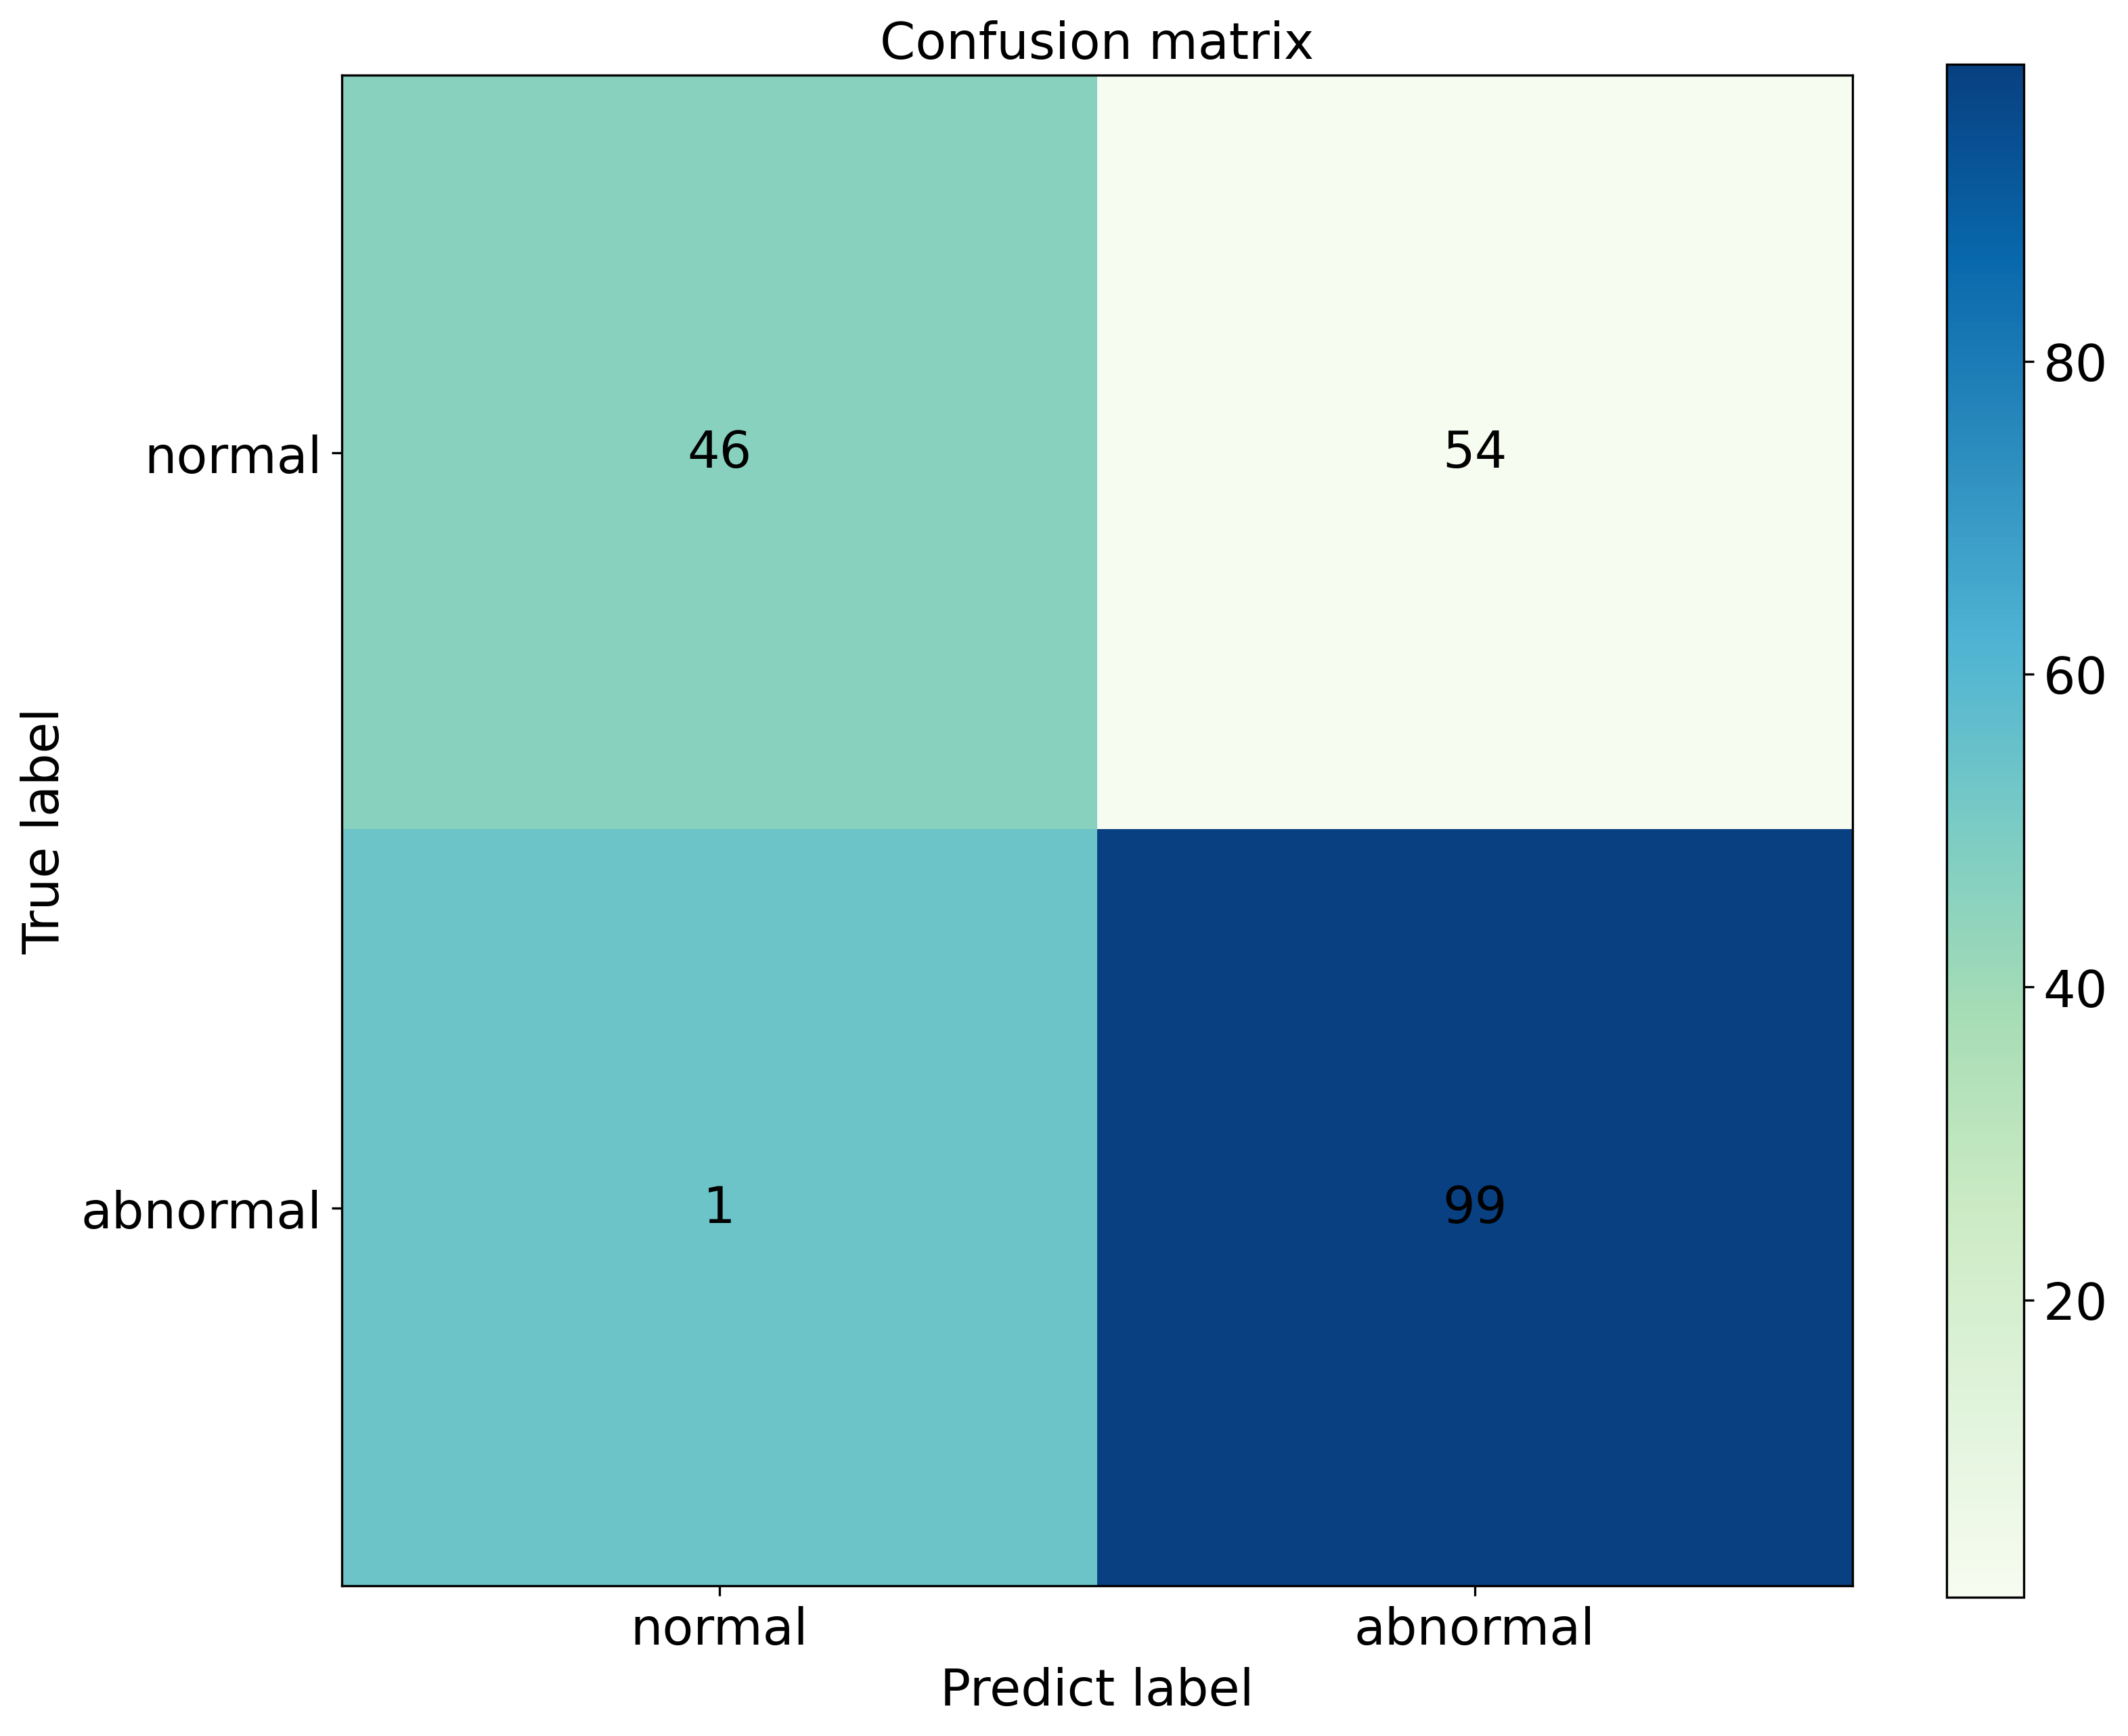

In [26]:
guess = ["normal","abnormal"]  # 注意自己的0，1样本顺序
fact = [ "normal","abnormal"]  # 注意自己的0，1样本顺序
classes = list(set(fact))
classes.sort(reverse=True)
r1=test_gpmatrix['CNNLSTM'].tolist()   # 混淆矩阵值。例：[[72,3],[28,97]]
 
plt.figure(figsize=(12,10), dpi=300, facecolor='w')       #设置plt窗口的大小
confusion =r1
plt.imshow(confusion, cmap=plt.cm.GnBu) # 调色
indices = range(len(confusion))
indices2 = range(3)
plt.xticks(indices, classes, rotation=0, fontsize=18)
plt.yticks([0.00,1.00], classes,fontsize=18)
plt.ylim(1.5 , -0.5)   #设置y的纵坐标的上下限
 
plt.title("Confusion matrix",fontdict={'weight':'normal','size': 18})
#设置color bar的标签大小
cb=plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.xlabel('Predict label',fontsize=18)
plt.ylabel('True label',fontsize=18)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
 
        if confusion[first_index][second_index]>200:
            color="w"
        else:
            color="black"
        plt.text(first_index, second_index, confusion[first_index][second_index],fontsize=18, color = color,verticalalignment='center',horizontalalignment='center',)
plt.show()

#### ROC曲线

AUC（Area Under Curve）被定义为ROC曲线下与坐标轴围成的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。AUC越接近1.0，检测方法真实性越高;等于0.5时，则真实性最低，无应用价值。

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(test_gppredict["CNNLSTM"], yTest)
lfpr, ltpr, lthresholds = metrics.roc_curve(test_predict["LSTM"], yTest)

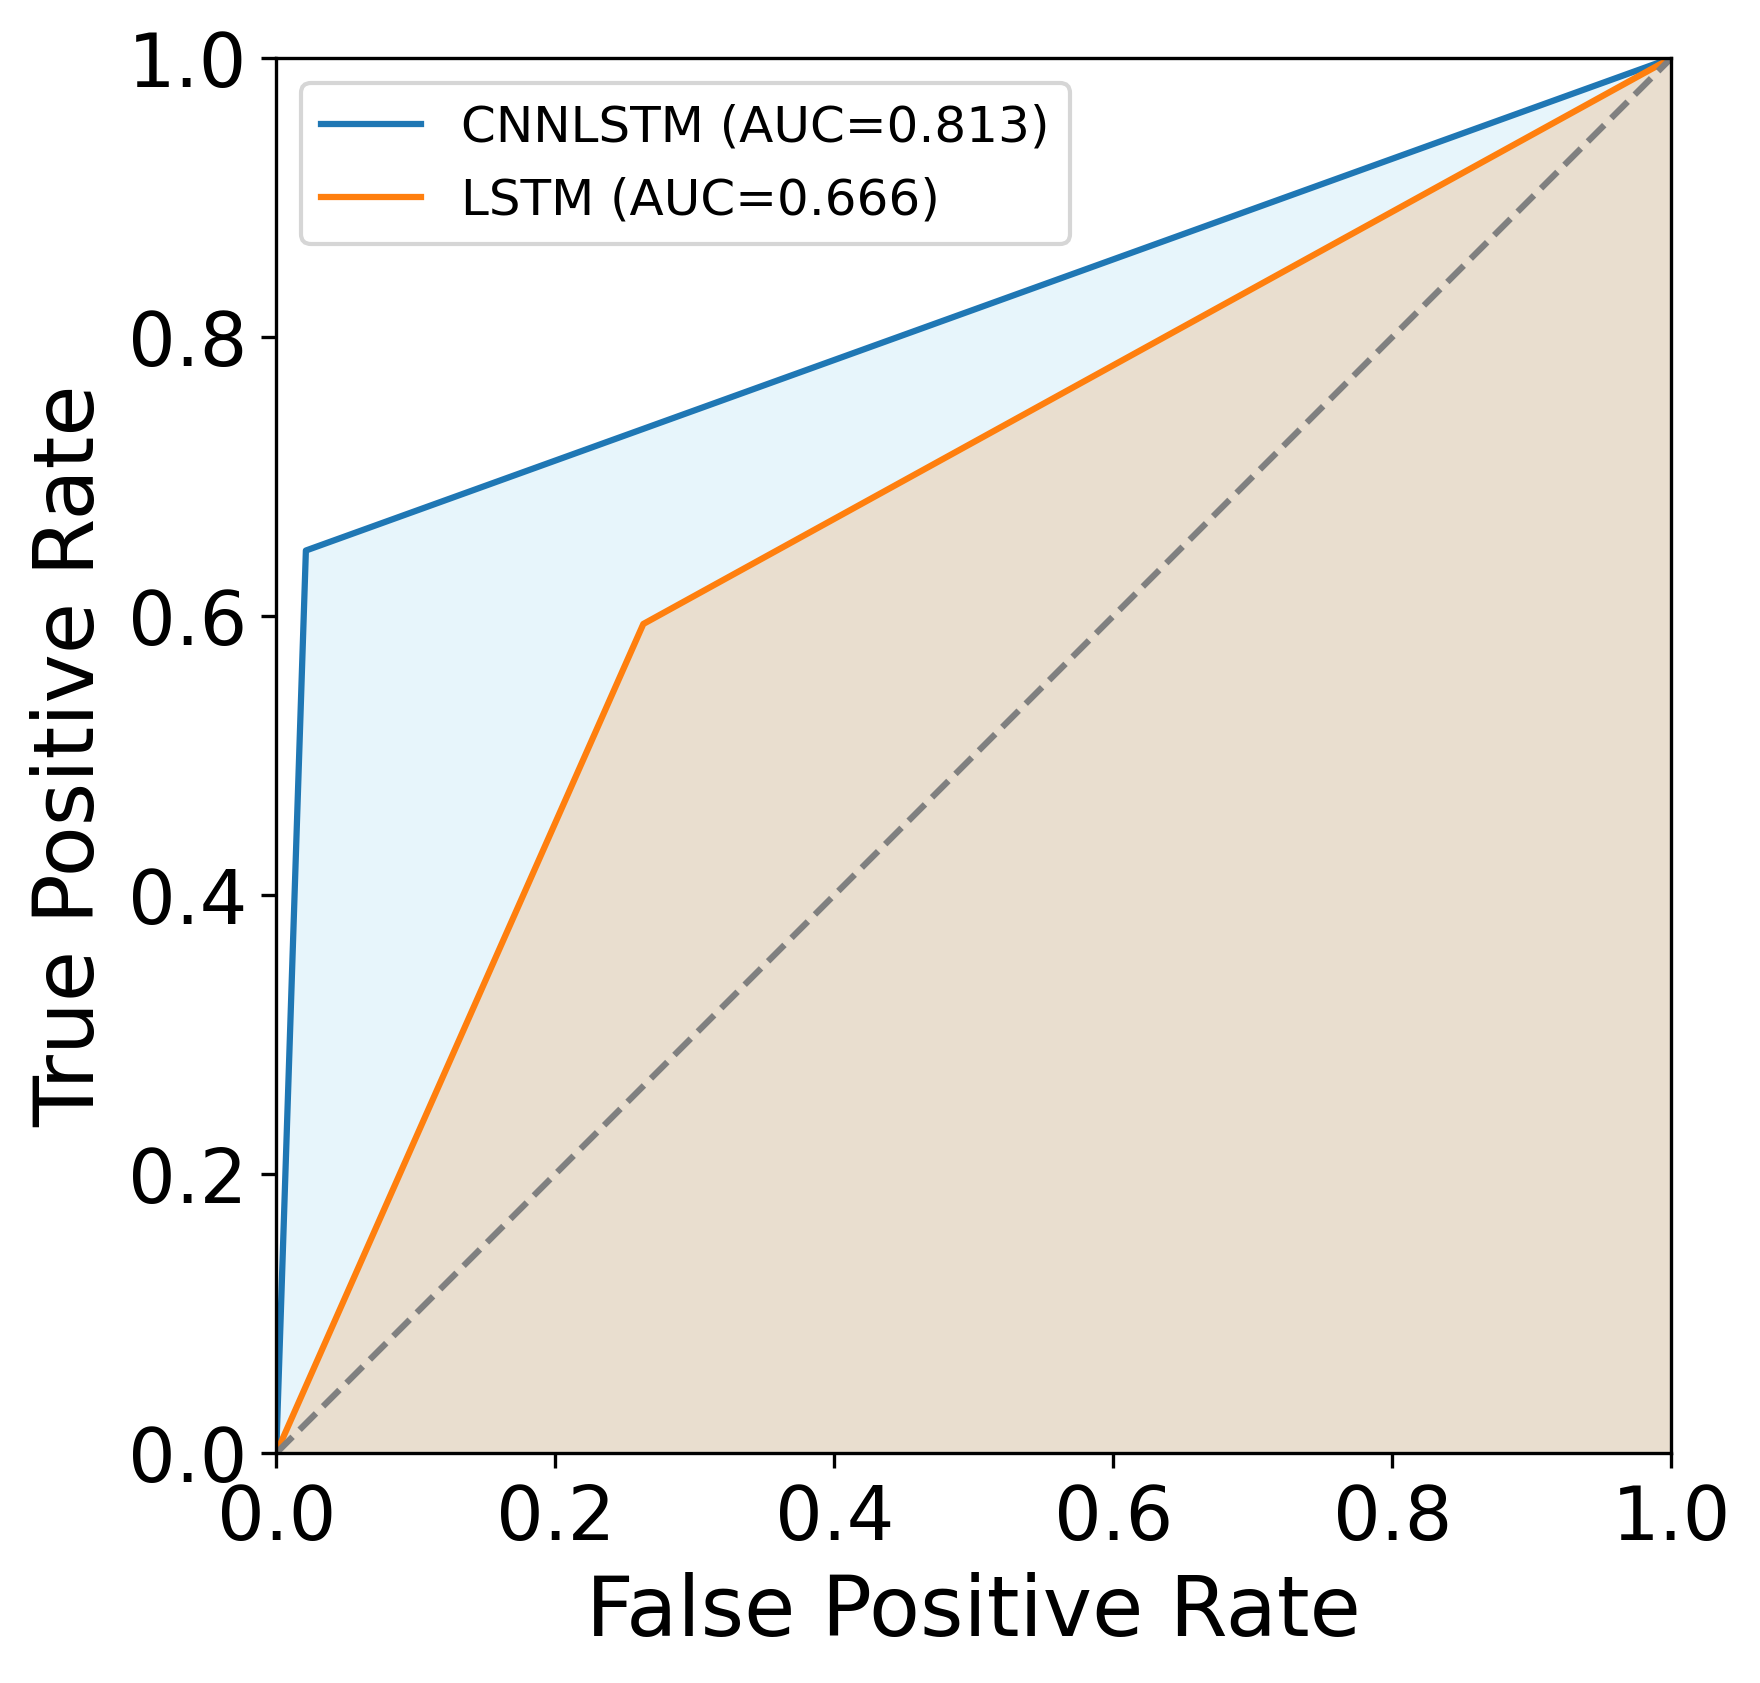

In [28]:
lw=1.5
fontsize=20

plt.figure(figsize=(6,7), dpi=300, facecolor='w')
plt.plot(fpr, tpr, lw=lw, label='{} (AUC={:.3f})'.format("CNNLSTM", metrics.auc(fpr, tpr)))
plt.plot(lfpr, ltpr, lw=lw, label='{} (AUC={:.3f})'.format("LSTM", metrics.auc(lfpr, ltpr)))
plt.plot([0, 1], [0, 1], '--', lw=lw, color = 'grey')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.fill_between(fpr, tpr, facecolor='skyblue', alpha=0.2)  # 颜色填充
plt.fill_between(lfpr, ltpr, facecolor='#f58220', alpha=0.2)  # 颜色填充
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.xlabel('False Positive Rate',fontsize=fontsize)
plt.ylabel('True Positive Rate',fontsize=fontsize)
# plt.title('ROC Curve',fontsize=fontsize)
plt.legend(fontsize=fontsize-8)
plt.show()